In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
import seaborn as sns
import scipy.stats as stats

# General processing
We start with reading in all spine files for all videos from all trackers. This is the basis for creating all the plots.

In [2]:
# Set plt dpi to 300
plt.rcParams['figure.dpi'] = 300

In [3]:
# Get list of video IDs
video_dir = '/Path/to/Larvae_Videos'
video_ids = [file.split('.')[0] for file in os.listdir(video_dir)]

In [12]:
parent_dir = '/Path/to/Larvae_Tracking_Benchmarking/Results'
dlc_dir = f'{parent_dir}/DeepLabCut/spine_files'
mwt_dir = f'{parent_dir}/MWT'
wf_ntp_dir = f'{parent_dir}/WF_NTP'
tierpsy_dir = f'{parent_dir}/Tierpsy'

In [13]:
# Read in all spine files for all videos from all trackers

# Create dictionary with video IDs as keys
spine_df = {}
for video_id in video_ids:
    # For each video ID, create a dictionary with tracker names as keys
    spine_df[video_id] = {}
    for tracker, dir in zip(['DLC', 'MWT', 'WF-NTP', 'Tierpsy'],
                            [dlc_dir, mwt_dir, wf_ntp_dir, tierpsy_dir]):
        # Read in spine file and save as dataframe
        spine_path = os.path.join(dir, video_id, video_id + '.spine')
        df = pd.read_csv(spine_path, sep=' ', header=None)
        columns_points = []
        rge = range(1, 8) if tracker == 'DLC' else range(1, 12)
        for i in rge:
            columns_points.extend([f'spinepoint{i}_x', f'spinepoint{i}_y'])
        df.columns = ['date_time', 'larva_id', 'time'] + columns_points

        # Add dataframe to dictionary
        spine_df[video_id][tracker] = df

In [14]:
# Read in target number of larvae for each video
df = pd.read_csv(
    '/Path/to/target_larvae_nr_18_videos.csv', sep='\n', skiprows=1, header=None)
target_nr_dict = {}
for index, row in df.iterrows():
    if ',' not in row[0]:
        row = row[0].replace(';', ',')  # Adation to German csv file
    row = row.split(',')

    # remove all '' from the list; they exist because the rows can have different lengths
    row = [x for x in row if x != '']

    # Save target number of larvae for each video as a list of tuples; the video ID is the key
    target_nr_dict[row[0]] = []
    for i in range(1, len(row), 2):
        # Append a tuple of (time, target_nr) to the list
        target_nr_dict[row[0]].append((float(row[i]), int(row[i + 1])))

# Plot number of tracked larvae

In [41]:
color = {'MWT': '#00bbd6', 'DLC': '#878a60', 'WF-NTP': '#961d4e', 'Tierpsy': '#faa32b'}

for video_id in video_ids:
    # Create figure
    fig = plt.figure(figsize=(4, 2.5))
    fig.title = video_id

    for tracker in ['DLC', 'MWT', 'WF-NTP', 'Tierpsy']:
        tracker_label = 'DeepLabCut' if tracker == 'DLC' else tracker

        # Add line at zero for unannotated frames for Tierpsy
        if tracker == 'Tierpsy':
            df = spine_df[video_id][tracker].groupby('time').larva_id.nunique().copy()
            min_time, max_time = df.index.min(), df.index.max()
            if min_time != 0.0:
                plt.plot([0, min_time, min_time], [0, 0, df.loc[min_time]], color=color[tracker])
            if max_time != 60.0:
                plt.plot([max_time, max_time, 60.0], [df.loc[max_time], 0, 0], color=color[tracker])

        # Plot number of larvae identified over time for the current tracker
        spine_df[video_id][tracker].groupby('time').larva_id.nunique().plot(color=color[tracker], label=tracker_label)

    # Plot target number of larvae over time as a step function
    x, y = [], []
    for target_time, target_nr in target_nr_dict[video_id]:
        x.append(target_time)
        y.append(target_nr)
    x.append(60.0)  # TODO: This will only work for our 60s long videos
    y.append(target_nr_dict[video_id][-1][1])
    plt.step(x, y, color='black', linestyle='--', where='post', linewidth=2.5, label='Ground Truth')

    # Format plot
    plt.gca().set_ylim(bottom=0)
    plt.xlabel('Time in Seconds')
    plt.ylabel('Number of Detected Larvae')
    ax = plt.gca()
    plt.ylim(bottom=-0.4)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_color("black")
        spine.set_linewidth(0.8)

    # Place legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Save plot
    plt.savefig(
        f'/Path/to/Plots/Nr_Tracked_Larvae/{video_id}.png', bbox_inches='tight')
    plt.close()

# Plot tracks

In [58]:
def plot_one_video(video_id, tracker):
    # Get first frame of video, we will plot the tracks on top of this
    cap = cv2.VideoCapture(f'{video_dir}/{video_id}.avi')
    ret, frame = cap.read()
    fig, ax = plt.subplots()
    ax.imshow(frame)

    # Get respective spine dataframe
    df = spine_df[video_id][tracker].copy()

    colors = ['#237194', '#00bbd6', '#878a60', '#faa32b', '#961d4e']
    color_map = LinearSegmentedColormap.from_list("custom_colormap", colors)

    # Get all larva IDs
    larva_id_list = df['larva_id'].unique().tolist()

    # For each larva, plot the track of the centroid
    for idx, larva_id in enumerate(larva_id_list):
        larva_df = df[df['larva_id'] == larva_id]

        # DeepLabCut predicts 7 spine points, all other trackers predict 11, thus the centroid is at a different index
        centroid = 4 if tracker == 'DLC' else 6
        x = list(larva_df[f'spinepoint{centroid}_x'])
        y = list(larva_df[f'spinepoint{centroid}_y'])
        time = list(larva_df['time'])

        # For MWT, switch x and y coordinates and divide by 0.073 to get the correct coordinates
        if tracker == 'MWT':
            # Divide every coordinate by 0.073
            x = [i / 0.073 for i in x]
            y = [i / 0.073 for i in y]
            x, y = y, x

        # Plot track as a line with a color corresponding to the time
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lines = LineCollection(segments, cmap=color_map, norm=plt.Normalize(0.0, 60.0))
        lines.set_array(np.array(time))
        ax.add_collection(lines)

    # Format plot
    plt.rc('font', size=30)
    cbar = plt.colorbar(lines, ax=ax)
    cbar.set_label('Time in Seconds', size=15)
    ax.autoscale()
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'/Path/to/Plots/Tracks/{tracker}_{video_id}.png', bbox_inches='tight')
    plt.close()

In [10]:
for i in range(18):
    plot_one_video(video_ids[i], 'MWT')

# Plot first frame of each video
Here we save the first frame of each video, which assists in putting the plots with the number of detected larvae into context

In [10]:
for video_id in video_ids:
    cap = cv2.VideoCapture(f'{video_dir}/{video_id}.avi')
    ret, frame = cap.read()
    fig, ax = plt.subplots()
    ax.imshow(frame)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'/Path/to/Plots/First_Frame/{video_id}.png', bbox_inches='tight')
    plt.close()

# Look at individual pose estimations
For DeepLabCut and MWT, we want to look at some individual pose estimations, meaning all annotated spine points for one frame

In [21]:
# Choose video and time
time = 3.0
video_id = 'A1DF39_A1_2022-07-12-184950-0000_ffv1'

In [66]:
for tracker in ['DLC', 'MWT']:
    # Get respective spine dataframe at the chosen time
    df = spine_df[video_id][tracker]
    df = df[df['time'] == time]

    print(f'{len(df)} Larvae found at {time} seconds for {tracker}')

    # Get the respective frame from the video at the chosen time
    cap = cv2.VideoCapture(f'{video_dir}/{video_id}.avi')
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(time * 30))
    ret, frame = cap.read()
    fig, ax = plt.subplots()
    ax.imshow(frame)

    rge = range(1, 8) if tracker == 'DLC' else range(1, 12)
    colors = ['#961d4e', '#961d4e', '#faa32b', '#878a60', '#00bbd6', '#237194']
    color_map = LinearSegmentedColormap.from_list("custom_colormap", colors, N=len(rge))
    for i in rge:
        x = df[f'spinepoint{i}_x'].values
        y = df[f'spinepoint{i}_y'].values

        if tracker == 'MWT':
            # Divide every coordinate by 0.073 and switch x and y
            x /= 0.073
            y /= 0.073
            x, y = y, x

        # Plot all spine points as a scatter plot using rainbow colors
        norm_value = i / len(rge)
        plt.scatter(x, y, color=color_map(norm_value), s=50, alpha=0.8)

    # Remove ticks
    plt.xticks([])
    plt.yticks([])

    # Cut so that only center worms (one worm away) are visible
    plt.xlim(420, 675)
    plt.ylim(645, 410)

    # Add legend for head and tail, use font size 14
    plt.scatter([], [], color='#961d4e', s=70, label='Head')
    plt.scatter([], [], color='#237194', s=70, label='Tail')
    plt.legend(fontsize=20)

    # Save plot
    plt.savefig(f'/Path/to/Plots/Pose_Estimation/{tracker}_{video_id}_{time}.png', bbox_inches='tight')
    plt.close()

7 Larvae found at 3.0 seconds for DLC
5 Larvae found at 3.0 seconds for MWT


# Boxplot: Error in detected larvae for all 18 videos

In [45]:
# Here, we just calculate the error, the plotting follows later

# For each of the 18 videos, calculate the average deviation from the target number of larvae
errors = {'DLC': [], 'MWT': [], 'WF-NTP': []}
for video_id in video_ids:
    for tracker in ['DLC', 'MWT', 'WF-NTP']:
        df = spine_df[video_id][tracker]
        nr_detected_per_time = df.groupby('time').larva_id.nunique()

        target_nr_list = target_nr_dict[video_id]
        cumulative_error = 0.0
        current_target_nr = np.Inf

        # Calculate cumulative error for one video by averaging the error over the whole video
        for time, detected_larvae in nr_detected_per_time.items():
            # Identify target number of larvae at the current time
            for target_time, target_nr in target_nr_list:
                if time >= target_time:
                    current_target_nr = target_nr
                elif time < target_time:
                    break

            # Add error to cumulative error
            cumulative_error += (detected_larvae - current_target_nr) / current_target_nr

        # Calculate average error for one video
        error = cumulative_error / len(nr_detected_per_time)

        # Append average error in percent to list of errors for the current tracker
        errors[tracker].append(error * 100)

In [61]:
# Print p-values for all combinations of trackers
for key1 in errors.keys():
    for key2 in errors.keys():
        if key1 != key2:
            p_val = stats.ttest_ind(errors[key1], errors[key2])[1]
            print(f'{key1} vs {key2}: {p_val}')

DLC vs MWT: 0.34229637482530095
DLC vs WF-NTP: 0.2687714455000229
MWT vs DLC: 0.34229637482530095
MWT vs WF-NTP: 0.04632716676567546
WF-NTP vs DLC: 0.2687714455000229
WF-NTP vs MWT: 0.04632716676567546


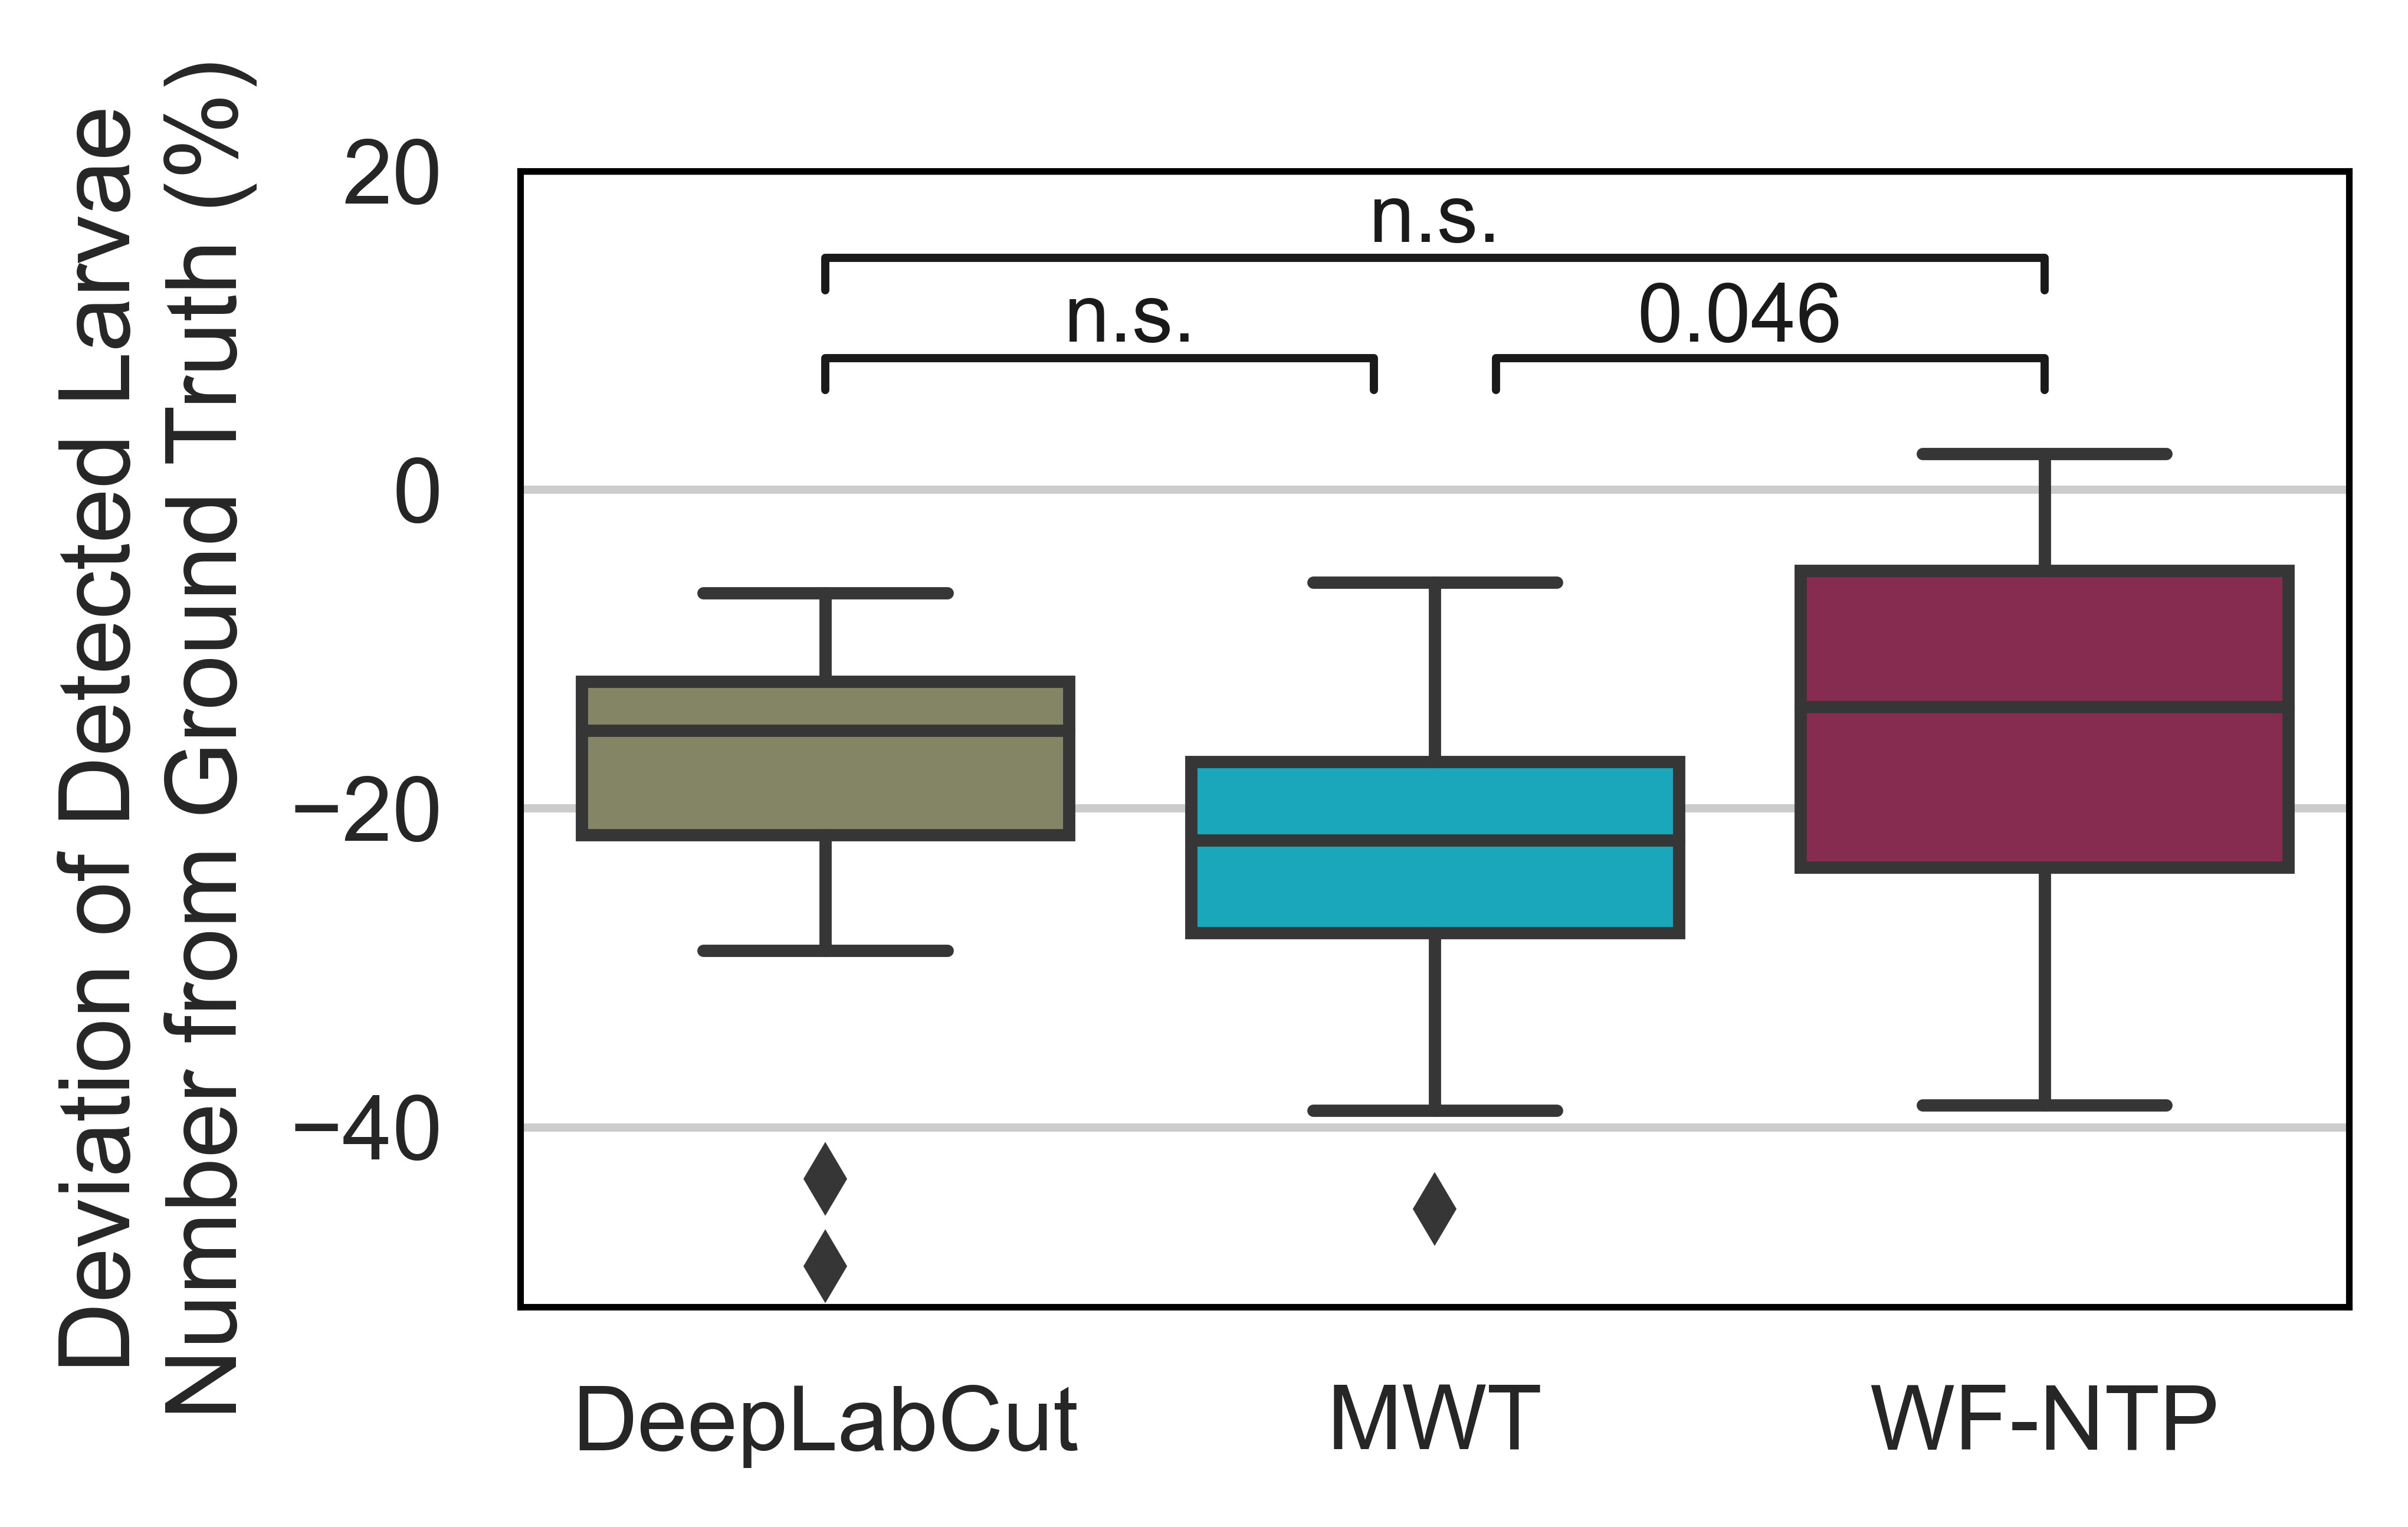

In [78]:
# Create figure
fig, ax = plt.subplots(figsize=(4, 2.5))

# Adjust layout of plot
sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette(['#878a60', '#00bbd6', '#961d4e']))

# Create dataframe with errors and plot as boxplot
df = pd.DataFrame(errors)
df = df.melt(var_name='Tracker', value_name='Average Error')
sns.boxplot(x='Tracker', y='Average Error', data=df)

# Format plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_color("black")
    spine.set_linewidth(0.8)
plt.ylim(top=20)

# Add significance stars
x1, x2, x3 = 0, 1, 2
y, h, col = df['Average Error'].max() + 4, 2, 'k'
plt.plot([x1, x1, x2 - 0.1, x2 - 0.1], [y, y + h, y + h, y], lw=1, c=col)
plt.plot([x2 + 0.1, x2 + 0.1, x3, x3], [y, y + h, y + h, y], lw=1, c=col)
plt.plot([x1, x1, x3, x3], [y * 2, (y * 2) + h, (y * 2) + h, y * 2], lw=1, c=col)
plt.text((x1 + x2) * .5, y + h, "n.s.", ha='center', va='bottom', color=col, fontsize=10)
plt.text((x2 + x3) * .5, y + h, "0.046", ha='center', va='bottom', color=col, fontsize=10)
plt.text((x1 + x3) * .5, y * 2 + h, "n.s.", ha='center', va='bottom', color=col, fontsize=10)

# Get x ticks and replace 'DLC' with 'DeepLabCut'
xticks = [x.get_text() for x in ax.get_xticklabels()]
xticks = ['DeepLabCut' if x == 'DLC' else x for x in xticks]
ax.set_xticklabels(xticks)

plt.ylabel('Deviation of Detected Larvae\nNumber from Ground Truth (%)')
plt.xlabel('')

plt.savefig(f'/Path/to/Plots/Boxplots/Boxplot_with_stats.png', bbox_inches='tight')

# Scatter plot for all 18 videos
Shows the number of detected larvae against the target number of larvae for each video. The plot is as a scatter plot where x is the target number of larvae and y is the number of detected larvae.

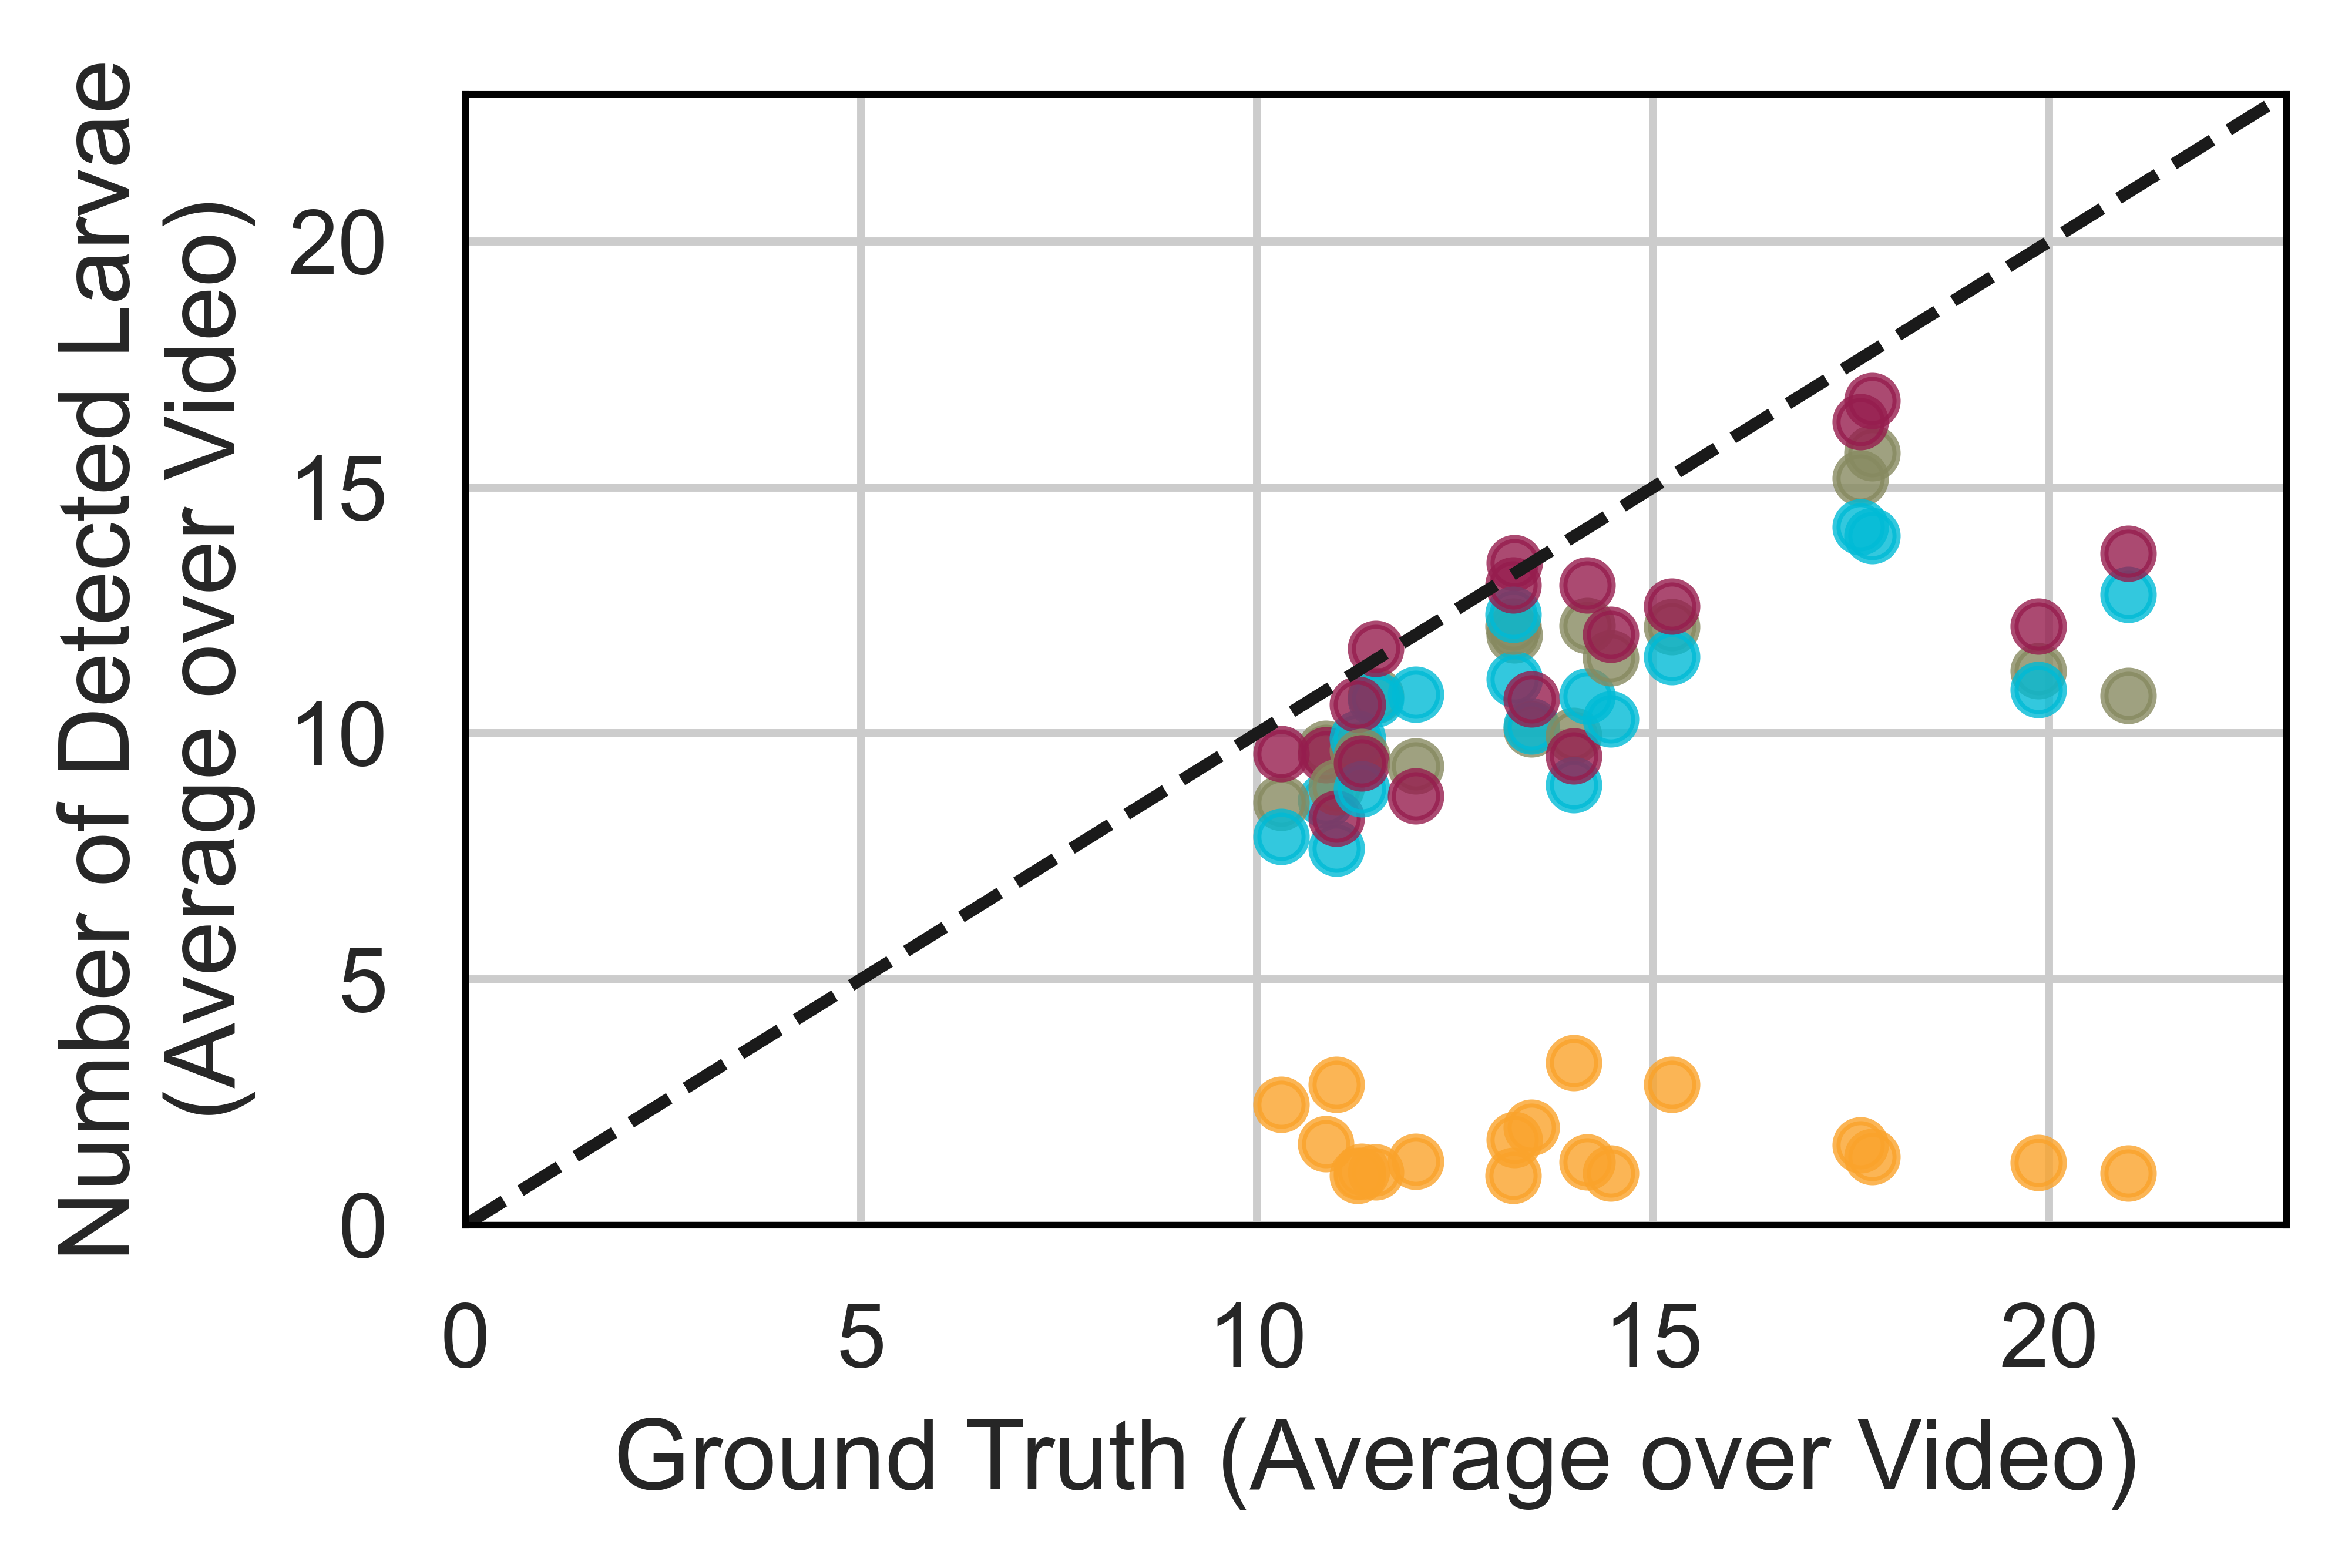

In [49]:
# For each video, plot the target number of larvae against the number of detected larvae
color_dict = {'MWT': '#00bbd6', 'DLC': '#878a60', 'WF-NTP': '#961d4e', 'Tierpsy': '#faa32b'}

# Create figure
plt.figure(figsize=(4, 2.5))
sns.set_theme(style="whitegrid")

for video_id in video_ids:
    # Get target number of larvae
    target_nr_list = target_nr_dict[video_id]

    # Get average target number of larvae over the whole video
    cumulative_nr = 0
    for frame in range(0, 1800):
        for target_time, target_nr in target_nr_list:
            target_frame = round(target_time * 30)
            if frame >= target_frame:
                current_target_nr = target_nr
            elif frame < target_frame:
                break
        cumulative_nr += current_target_nr
    target_nr = cumulative_nr / 1800

    # For each tracker, get average number of detected larvae over the whole video
    for tracker in ['DLC', 'MWT', 'WF-NTP', 'Tierpsy']:
        df = spine_df[video_id][tracker]
        nr_detected_per_time = df.groupby('time').larva_id.nunique()
        cumulative_nr = 0
        for time, detected_larvae in nr_detected_per_time.items():
            cumulative_nr += detected_larvae
        detected_nr = cumulative_nr / len(nr_detected_per_time)

        # Plot as scatter plot
        plt.scatter(target_nr, detected_nr, color=color_dict[tracker], s=35, alpha=0.8)

# Add x=y line (ideal prediction)
plt.plot([0, 100], [0, 100], color='k', linestyle='--')

#Format plot
plt.xlim(0, 23)
plt.ylim(0, 23)
plt.xlabel('Ground Truth (Average over Video)')
plt.ylabel('Number of Detected Larvae\n(Average over Video)')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_color("black")
    spine.set_linewidth(0.8)

plt.savefig(f'Path/to/Plots/Boxplots/Scatter.png', bbox_inches='tight')